In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# 1. Baseline model

In [ ]:
# Simple CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

print('done')

done


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size   = 32
num_epochs   = 10
learning_rate= 1e-3
num_classes  = 4  # glioma, meningioma, no_tumor, pituitary

best_val_loss = float('inf')
patience_counter = 0
patience = 5  # The number of epochs to wait for improvement before stopping

In [ ]:
# If your images are RGB (most are with ImageFolder), use 3 means/stds:
# If they are truly grayscale, add transforms.Grayscale(1) before ToTensor and keep single mean/std.
transform = transforms.Compose([
    # transforms.Grayscale(1),                 # uncomment if your data is grayscale on disk
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],      # if RGB
                         [0.5, 0.5, 0.5]),
    # transforms.Normalize([0.5], [0.5]),      # if grayscale (use with Grayscale(1))
])

# Datasets
base_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=transform)

# Labels for stratified split (from the *same* dataset you will subset)
y = [label for _, label in base_train_dataset.samples]

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.arange(len(y)), y))

# Build subsets from the SAME base dataset
train_dataset = Subset(base_train_dataset, train_idx)
val_dataset   = Subset(base_train_dataset, val_idx)

# Optional sanity checks to catch misalignment early
assert max(train_idx) < len(base_train_dataset) and max(val_idx) < len(base_train_dataset)
assert set(train_idx).isdisjoint(val_idx)

# DataLoaders
g = torch.Generator().manual_seed(42)  # reproducible shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, generator=g)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 2592 | Val: 648 | Test: 424


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Get class distribution
train_classes = [label for _, label in train_dataset]
class_counts = Counter(train_classes)

# Print class distribution
print("Training dataset class distribution:")
for class_idx, count in class_counts.items():
    class_name = train_dataset.dataset.classes[class_idx]
    print(f"{class_name}: {count}")

Training dataset class distribution:
pituitary_tumor: 837
no_tumor: 316
meningioma_tumor: 754
glioma_tumor: 685


In [ ]:
model = BrainTumorCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)')):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%')


    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images_val, labels_val in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = model(images_val)
            loss_val = criterion(outputs_val, labels_val)

            running_val_loss += loss_val.item() * images_val.size(0)
            _, predicted_val = outputs_val.max(1)
            total_val += labels_val.size(0)
            correct_val += predicted_val.eq(labels_val).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = 100. * correct_val / total_val
    val_losses.append(epoch_val_loss)

    # After the validation loop...
epoch_val_loss = running_val_loss / len(val_loader.dataset)
val_accuracy = 100. * correct_val / total_val
val_losses.append(epoch_val_loss)
print(f'Epoch {epoch+1}/{num_epochs} | Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')

# Early Stopping Logic
if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    patience_counter = 0
    # Optional: Save the best model state
    # torch.save(model.state_dict(), 'best_model.pth')
else:
    patience_counter += 1
    print(f"Patience: {patience_counter}/{patience}")

if patience_counter >= patience:
    print("Early stopping triggered!")
    break

    print(f'Epoch {epoch+1}/{num_epochs} | Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/10 (Training):  26%|██▌       | 21/81 [00:05<00:09,  6.55it/s]

Epoch [1/10], Step [20/81], Loss: 1.4539


Epoch 1/10 (Training):  51%|█████     | 41/81 [00:10<00:10,  3.79it/s]

Epoch [1/10], Step [40/81], Loss: 0.7697


Epoch 1/10 (Training):  75%|███████▌  | 61/81 [00:14<00:03,  6.18it/s]

Epoch [1/10], Step [60/81], Loss: 0.9039


Epoch 1/10 (Training): 100%|██████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch [1/10], Step [80/81], Loss: 1.0485
Epoch 1/10 | Train Loss: 0.9984 | Train Accuracy: 60.42%


Epoch 2/10 (Training):  23%|██▎       | 19/81 [00:04<00:14,  4.26it/s]

Epoch [2/10], Step [20/81], Loss: 0.6442


Epoch 2/10 (Training):  48%|████▊     | 39/81 [00:08<00:06,  6.18it/s]

Epoch [2/10], Step [40/81], Loss: 0.7150


Epoch 2/10 (Training):  75%|███████▌  | 61/81 [00:12<00:03,  5.37it/s]

Epoch [2/10], Step [60/81], Loss: 0.5330


Epoch 2/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  4.95it/s]


Epoch [2/10], Step [80/81], Loss: 0.7413
Epoch 2/10 | Train Loss: 0.6200 | Train Accuracy: 76.16%


Epoch 3/10 (Training):  25%|██▍       | 20/81 [00:04<00:10,  6.07it/s]

Epoch [3/10], Step [20/81], Loss: 0.5045


Epoch 3/10 (Training):  49%|████▉     | 40/81 [00:07<00:06,  6.37it/s]

Epoch [3/10], Step [40/81], Loss: 0.4216


Epoch 3/10 (Training):  74%|███████▍  | 60/81 [00:12<00:03,  5.56it/s]

Epoch [3/10], Step [60/81], Loss: 0.2503


Epoch 3/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  4.89it/s]


Epoch [3/10], Step [80/81], Loss: 0.3710
Epoch 3/10 | Train Loss: 0.4256 | Train Accuracy: 82.83%


Epoch 4/10 (Training):  23%|██▎       | 19/81 [00:05<00:15,  4.11it/s]

Epoch [4/10], Step [20/81], Loss: 0.2336


Epoch 4/10 (Training):  48%|████▊     | 39/81 [00:09<00:07,  5.97it/s]

Epoch [4/10], Step [40/81], Loss: 0.2295


Epoch 4/10 (Training):  73%|███████▎  | 59/81 [00:12<00:03,  5.87it/s]

Epoch [4/10], Step [60/81], Loss: 0.2881


Epoch 4/10 (Training):  98%|█████████▊| 79/81 [00:16<00:00,  5.69it/s]

Epoch [4/10], Step [80/81], Loss: 0.1572


Epoch 4/10 (Training): 100%|██████████| 81/81 [00:17<00:00,  4.76it/s]


Epoch 4/10 | Train Loss: 0.3035 | Train Accuracy: 88.77%


Epoch 5/10 (Training):  26%|██▌       | 21/81 [00:04<00:09,  6.16it/s]

Epoch [5/10], Step [20/81], Loss: 0.1333


Epoch 5/10 (Training):  49%|████▉     | 40/81 [00:08<00:08,  4.78it/s]

Epoch [5/10], Step [40/81], Loss: 0.2491


Epoch 5/10 (Training):  74%|███████▍  | 60/81 [00:13<00:03,  5.43it/s]

Epoch [5/10], Step [60/81], Loss: 0.3903


Epoch 5/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  4.82it/s]


Epoch [5/10], Step [80/81], Loss: 0.1630
Epoch 5/10 | Train Loss: 0.2166 | Train Accuracy: 92.40%


Epoch 6/10 (Training):  23%|██▎       | 19/81 [00:05<00:11,  5.18it/s]

Epoch [6/10], Step [20/81], Loss: 0.1568


Epoch 6/10 (Training):  48%|████▊     | 39/81 [00:09<00:07,  5.66it/s]

Epoch [6/10], Step [40/81], Loss: 0.1482


Epoch 6/10 (Training):  73%|███████▎  | 59/81 [00:12<00:03,  6.24it/s]

Epoch [6/10], Step [60/81], Loss: 0.0234


Epoch 6/10 (Training): 100%|██████████| 81/81 [00:17<00:00,  4.52it/s]


Epoch [6/10], Step [80/81], Loss: 0.1166
Epoch 6/10 | Train Loss: 0.1581 | Train Accuracy: 95.02%


Epoch 7/10 (Training):  23%|██▎       | 19/81 [00:04<00:10,  5.71it/s]

Epoch [7/10], Step [20/81], Loss: 0.1222


Epoch 7/10 (Training):  48%|████▊     | 39/81 [00:08<00:10,  3.87it/s]

Epoch [7/10], Step [40/81], Loss: 0.2506


Epoch 7/10 (Training):  73%|███████▎  | 59/81 [00:12<00:03,  6.14it/s]

Epoch [7/10], Step [60/81], Loss: 0.1624


Epoch 7/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  4.91it/s]


Epoch [7/10], Step [80/81], Loss: 0.0616
Epoch 7/10 | Train Loss: 0.1223 | Train Accuracy: 95.72%


Epoch 8/10 (Training):  23%|██▎       | 19/81 [00:04<00:10,  5.85it/s]

Epoch [8/10], Step [20/81], Loss: 0.0395


Epoch 8/10 (Training):  48%|████▊     | 39/81 [00:08<00:06,  6.09it/s]

Epoch [8/10], Step [40/81], Loss: 0.0252


Epoch 8/10 (Training):  73%|███████▎  | 59/81 [00:11<00:03,  6.16it/s]

Epoch [8/10], Step [60/81], Loss: 0.2038


Epoch 8/10 (Training): 100%|██████████| 81/81 [00:17<00:00,  4.73it/s]


Epoch [8/10], Step [80/81], Loss: 0.4021
Epoch 8/10 | Train Loss: 0.1041 | Train Accuracy: 96.49%


Epoch 9/10 (Training):  23%|██▎       | 19/81 [00:03<00:10,  5.76it/s]

Epoch [9/10], Step [20/81], Loss: 0.0480


Epoch 9/10 (Training):  48%|████▊     | 39/81 [00:08<00:10,  3.99it/s]

Epoch [9/10], Step [40/81], Loss: 0.0745


Epoch 9/10 (Training):  73%|███████▎  | 59/81 [00:12<00:03,  6.50it/s]

Epoch [9/10], Step [60/81], Loss: 0.0572


Epoch 9/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  7.33it/s]

Epoch [9/10], Step [80/81], Loss: 0.0559


Epoch 9/10 (Training): 100%|██████████| 81/81 [00:16<00:00,  5.04it/s]


Epoch 9/10 | Train Loss: 0.0627 | Train Accuracy: 98.11%


Epoch 10/10 (Training):  23%|██▎       | 19/81 [00:04<00:10,  5.91it/s]

Epoch [10/10], Step [20/81], Loss: 0.0144


Epoch 10/10 (Training):  49%|████▉     | 40/81 [00:08<00:05,  7.13it/s]

Epoch [10/10], Step [40/81], Loss: 0.0151


Epoch 10/10 (Training):  73%|███████▎  | 59/81 [00:12<00:04,  5.45it/s]

Epoch [10/10], Step [60/81], Loss: 0.0575


Epoch 10/10 (Training): 100%|██████████| 81/81 [00:17<00:00,  4.70it/s]


Epoch [10/10], Step [80/81], Loss: 0.0496
Epoch 10/10 | Train Loss: 0.0556 | Train Accuracy: 98.11%


Epoch 10/10 (Validation): 100%|██████████| 21/21 [00:03<00:00,  5.59it/s]

Epoch 10/10 | Validation Loss: 0.3790 | Validation Accuracy: 89.81%


SyntaxError: 'break' outside loop (ipython-input-114788958.py, line 79)

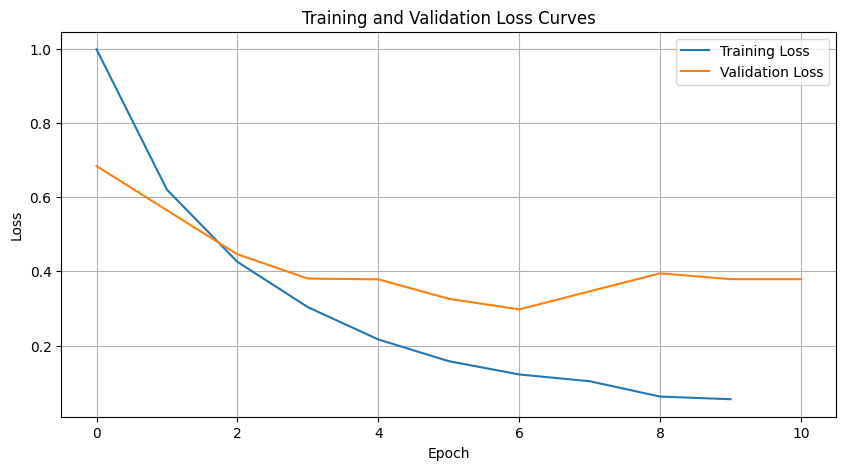

In [ ]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.66      0.21      0.32       100
meningioma_tumor       0.70      0.88      0.78       135
        no_tumor       0.66      0.97      0.79       115
 pituitary_tumor       0.87      0.64      0.73        74

        accuracy                           0.71       424
       macro avg       0.72      0.68      0.66       424
    weighted avg       0.71      0.71      0.67       424



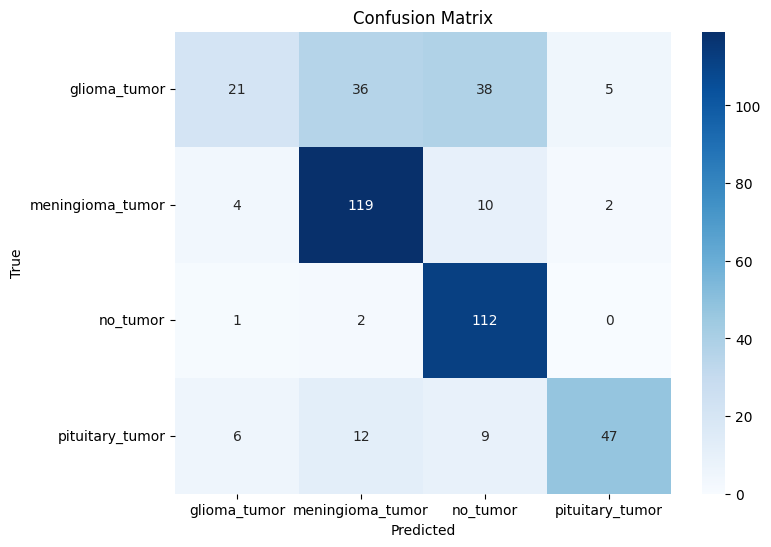

In [ ]:
# Evaluation on Test Set
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. Fine-tune pretrained model

Number of classes: 4
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
/tmp/ipython-input-1431950156.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
/tmp/ipython-input-1431950156.py:207: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipytho

Epoch 001/40 | train_loss=0.9816 | val_loss=0.8001 | val_acc=0.6420 | lr=4.03e-05
Epoch 002/40 | train_loss=0.3179 | val_loss=0.2806 | val_acc=0.9151 | lr=6.97e-05
Epoch 003/40 | train_loss=0.1380 | val_loss=0.3205 | val_acc=0.8627 | lr=1.14e-04
Epoch 004/40 | train_loss=0.1168 | val_loss=0.2667 | val_acc=0.8781 | lr=1.65e-04
Epoch 005/40 | train_loss=0.0922 | val_loss=0.2967 | val_acc=0.9043 | lr=2.17e-04
Epoch 006/40 | train_loss=0.0810 | val_loss=0.1296 | val_acc=0.9552 | lr=2.61e-04
Epoch 007/40 | train_loss=0.0726 | val_loss=0.1406 | val_acc=0.9383 | lr=2.90e-04
Epoch 008/40 | train_loss=0.1124 | val_loss=0.1750 | val_acc=0.9213 | lr=3.00e-04
Epoch 009/40 | train_loss=0.0801 | val_loss=0.0739 | val_acc=0.9676 | lr=2.99e-04
Epoch 010/40 | train_loss=0.0475 | val_loss=0.0974 | val_acc=0.9630 | lr=2.97e-04
Epoch 011/40 | train_loss=0.0144 | val_loss=0.2352 | val_acc=0.9336 | lr=2.94e-04
Epoch 012/40 | train_loss=0.0221 | val_loss=0.0858 | val_acc=0.9738 | lr=2.89e-04
Epoch 013/40 | t

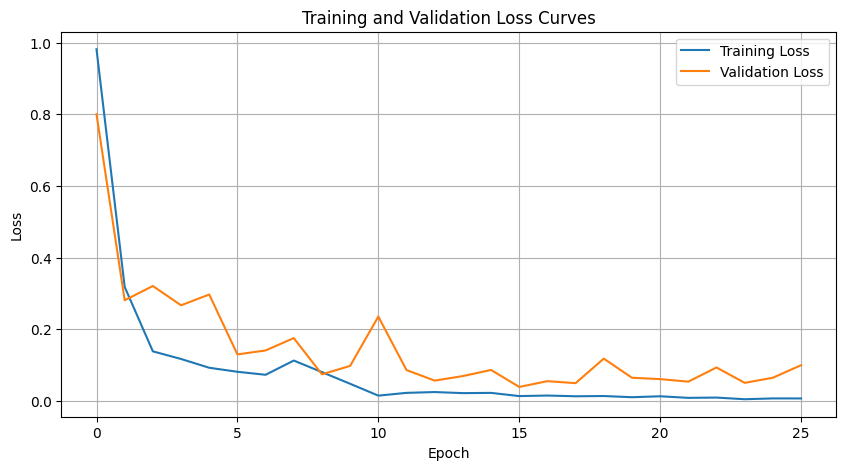


Final Test Acc: 0.7830

Classification report (TEST):
                  precision    recall  f1-score   support

    glioma_tumor      1.000     0.240     0.387       100
meningioma_tumor      0.756     0.985     0.855       135
        no_tumor      0.710     1.000     0.830       115
 pituitary_tumor      0.968     0.811     0.882        74

        accuracy                          0.783       424
       macro avg      0.858     0.759     0.739       424
    weighted avg      0.838     0.783     0.743       424



NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
import os, math, copy, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --------------------------
# Config - SET YOUR PATHS HERE!
# --------------------------
train_dir = os.path.join(os.getcwd(), 'Training')  # UPDATE THIS PATH
test_dir = os.path.join(os.getcwd(), 'Testing')    # UPDATE THIS PATH

model_name    = "resnet50"           # choose: "resnet50" or "efficientnet_b0"
epochs        = 40                   # 30–40 recommended
batch_size    = 32
max_lr        = 3e-4                 # OneCycle peak LR
weight_decay  = 1e-4
num_workers   = 4
seed          = 42
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# Early Stopping Parameters
patience = 10  # Number of epochs to wait after last improvement
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0


# -----------------------
# Define base transforms first - THIS FIXES THE base_tf ERROR!
# -----------------------
if model_name == "resnet50":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
elif model_name == "efficientnet_b0":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
else:
    raise ValueError("Unsupported model_name")

# -----------------------
# Define transforms
# -----------------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.85, 1.0)),
    transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip(p=0.5),  # enable only if flips make sense anatomically
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tf = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tf = val_tf  # usually same as val

# -----------------------
# Datasets
# -----------------------
base_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_tf)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=test_tf)

# NOW we can determine num_classes
num_classes = len(base_train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {base_train_dataset.classes}")

# Stratified split
y = [label for _, label in base_train_dataset.samples]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.arange(len(y)), y))

train_dataset = Subset(base_train_dataset, train_idx)
# Important: validation subset must apply val_tf (not train_tf), so re-wrap
base_val_dataset = datasets.ImageFolder(root=train_dir, transform=val_tf)
val_dataset   = Subset(base_val_dataset, val_idx)

# Sanity checks
assert set(train_idx).isdisjoint(val_idx)

# --------------------------
# Class weights (inverse frequency) + sampler
# --------------------------
# Targets only from the TRAIN subset (use indices!)
train_targets = np.array([base_train_dataset.samples[i][1] for i in train_idx])
class_counts = torch.bincount(torch.tensor(train_targets), minlength=num_classes).float().clamp(min=1.0)

# Weighted CE (normalized)
cls_weights = (class_counts.sum() / (num_classes * class_counts)).to(device)

# Per-sample weights aligned to the Subset order
subset_weights = torch.tensor([1.0 / class_counts[base_train_dataset.samples[i][1]] for i in train_idx],
                              dtype=torch.double)
sampler = WeightedRandomSampler(weights=subset_weights,
                                num_samples=len(subset_weights),
                                replacement=True)

# -----------------------
# DataLoaders
# -----------------------
# Rebuild loaders: sampler for train, vanilla for val/test
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# --------------------------
# Model (choose one)
# --------------------------

if model_name == "resnet50":
    from torchvision.models import ResNet50_Weights
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = models.resnet50(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

elif model_name == "efficientnet_b0":
    from torchvision.models import EfficientNet_B0_Weights
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

else:
    raise ValueError("model_name must be 'resnet50' or 'efficientnet_b0'")

model = model.to(device)

# --------------------------
# Loss / Optimizer / OneCycleLR
# --------------------------
criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=10.0
)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

# --------------------------
# Eval helper
# --------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    running_loss = 0.0 # Added to calculate validation loss
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y) # Calculate validation loss
        running_loss += loss.item() * x.size(0) # Accumulate validation loss
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        correct += (preds == y).sum().item()
        total += y.size(0)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = running_loss / total # Calculate average validation loss
    return (correct / total), all_labels, all_preds, avg_loss # Return validation loss

# --------------------------
# Train loop (AMP + OneCycle + best checkpoint + Early Stopping)
# --------------------------
best_w = copy.deepcopy(model.state_dict())
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0
t0 = time.time()
train_losses = [] # List to store training losses
val_losses = []   # List to store validation losses


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(train_loss) # Append training loss

    val_acc, _, _, val_loss = evaluate(model, val_loader) # Get validation loss
    val_losses.append(val_loss) # Append validation loss


    if val_loss < best_val_loss: # Check if validation loss improved
        best_val_loss = val_loss
        best_w = copy.deepcopy(model.state_dict())
        patience_counter = 0 # Reset patience counter
    else:
        patience_counter += 1 # Increment patience counter

    print(f"Epoch {epoch+1:03d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} " # Added validation loss to output
          f"| lr={scheduler.get_last_lr()[0]:.2e}")

    # Early Stopping Check
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break # Break the training loop

model.load_state_dict(best_w)

# --------------------------
# Plotting Loss Curves
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# --------------------------
# Final validation report
# --------------------------
test_acc, y_true, y_pred, _ = evaluate(model, test_loader) # Added _ to ignore validation loss
print(f"\nFinal Test Acc: {test_acc:.4f}")
print("\nClassification report (TEST):")
print(classification_report(y_true, y_pred, target_names=[c for c in base_train_dataset.classes], digits=3))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion matrix (TEST):")
print(confusion_matrix(y_true, y_pred))

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'all_labels' is not defined

# 3. Data augmentation

In [ ]:
import os, math, copy, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --------------------------
# Config - SET YOUR PATHS HERE!
# --------------------------
train_dir = os.path.join(os.getcwd(), 'Training')  # UPDATE THIS PATH
test_dir = os.path.join(os.getcwd(), 'Testing')    # UPDATE THIS PATH

model_name    = "resnet50"           # choose: "resnet50" or "efficientnet_b0"
epochs        = 40                   # 30–40 recommended
batch_size    = 32
max_lr        = 3e-4                 # OneCycle peak LR
weight_decay  = 1e-4
num_workers   = 4
seed          = 42
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# Early Stopping Parameters
patience = 10  # Number of epochs to wait after last improvement
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0


# -----------------------
# Define base transforms first - THIS FIXES THE base_tf ERROR!
# -----------------------
if model_name == "resnet50":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
elif model_name == "efficientnet_b0":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
else:
    raise ValueError("Unsupported model_name")

# -----------------------
# Define transforms
# -----------------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.85, 1.0)),
    transforms.RandomRotation(15), # Increased rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Added color jitter
    transforms.GaussianBlur(kernel_size=3), # Added Gaussian blur
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5), # Added affine transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)), # Added Gaussian noise
])

val_tf = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tf = val_tf  # usually same as val

# -----------------------
# Datasets
# -----------------------
base_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_tf)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=test_tf)

# NOW we can determine num_classes
num_classes = len(base_train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {base_train_dataset.classes}")

# Stratified split
y = [label for _, label in base_train_dataset.samples]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.arange(len(y)), y))

train_dataset = Subset(base_train_dataset, train_idx)
# Important: validation subset must apply val_tf (not train_tf), so re-wrap
base_val_dataset = datasets.ImageFolder(root=train_dir, transform=val_tf)
val_dataset   = Subset(base_val_dataset, val_idx)

# Sanity checks
assert set(train_idx).isdisjoint(val_idx)

# --------------------------
# Class weights (inverse frequency) + sampler
# --------------------------
# Targets only from the TRAIN subset (use indices!)
train_targets = np.array([base_train_dataset.samples[i][1] for i in train_idx])
class_counts = torch.bincount(torch.tensor(train_targets), minlength=num_classes).float().clamp(min=1.0)

# Weighted CE (normalized)
cls_weights = (class_counts.sum() / (num_classes * class_counts)).to(device)

# Per-sample weights aligned to the Subset order
subset_weights = torch.tensor([1.0 / class_counts[base_train_dataset.samples[i][1]] for i in train_idx],
                              dtype=torch.double)
sampler = WeightedRandomSampler(weights=subset_weights,
                                num_samples=len(subset_weights),
                                replacement=True)

# -----------------------
# DataLoaders
# -----------------------
# Rebuild loaders: sampler for train, vanilla for val/test
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# --------------------------
# Model (choose one)
# --------------------------

if model_name == "resnet50":
    from torchvision.models import ResNet50_Weights
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = models.resnet50(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

elif model_name == "efficientnet_b0":
    from torchvision.models import EfficientNet_B0_Weights
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

else:
    raise ValueError("model_name must be 'resnet50' or 'efficientnet_b0'")

model = model.to(device)

# --------------------------
# Loss / Optimizer / OneCycleLR
# --------------------------
criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=10.0
)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

# --------------------------
# Eval helper
# --------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    running_loss = 0.0 # Added to calculate validation loss
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y) # Calculate validation loss
        running_loss += loss.item() * x.size(0) # Accumulate validation loss
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        correct += (preds == y).sum().item()
        total += y.size(0)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = running_loss / total # Calculate average validation loss
    return (correct / total), all_labels, all_preds, avg_loss # Return validation loss

# --------------------------
# Train loop (AMP + OneCycle + best checkpoint + Early Stopping)
# --------------------------
best_w = copy.deepcopy(model.state_dict())
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0
t0 = time.time()
train_losses = [] # List to store training losses
val_losses = []   # List to store validation losses


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(train_loss) # Append training loss

    val_acc, _, _, val_loss = evaluate(model, val_loader) # Get validation loss
    val_losses.append(val_loss) # Append validation loss


    if val_loss < best_val_loss: # Check if validation loss improved
        best_val_loss = val_loss
        best_w = copy.deepcopy(model.state_dict())
        patience_counter = 0 # Reset patience counter
    else:
        patience_counter += 1 # Increment patience counter

    print(f"Epoch {epoch+1:03d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} " # Added validation loss to output
          f"| lr={scheduler.get_last_lr()[0]:.2e}")

    # Early Stopping Check
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break # Break the training loop

model.load_state_dict(best_w)
print(f"\nTraining done in {(time.time()-t0)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

# --------------------------
# Plotting Loss Curves
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# --------------------------
# Final validation report
# --------------------------
test_acc, y_true, y_pred, _ = evaluate(model, test_loader) # Added _ to ignore validation loss
print(f"\nFinal Test Acc: {test_acc:.4f}")
print("\nClassification report (TEST):")
print(classification_report(y_true, y_pred, target_names=[c for c in base_train_dataset.classes], digits=3))

print("\nConfusion matrix (TEST):")
print(confusion_matrix(y_true, y_pred))

Number of classes: 4
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]
/tmp/ipython-input-1342538244.py:166: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
/tmp/ipython-input-1342538244.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
/tmp/ipython-input-1342538244.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Epoch 001/40 | train_loss=1.0983 | val_loss=1.1471 | val_acc=0.3056 | lr=4.03e-05
Epoch 002/40 | train_loss=0.4782 | val_loss=0.5624 | val_acc=0.7608 | lr=6.97e-05
Epoch 003/40 | train_loss=0.2098 | val_loss=1.1410 | val_acc=0.4444 | lr=1.14e-04
Epoch 004/40 | train_loss=0.1469 | val_loss=0.2744 | val_acc=0.8966 | lr=1.65e-04
Epoch 005/40 | train_loss=0.1099 | val_loss=0.2738 | val_acc=0.8627 | lr=2.17e-04
Epoch 006/40 | train_loss=0.1261 | val_loss=0.1573 | val_acc=0.9367 | lr=2.61e-04
Epoch 007/40 | train_loss=0.0749 | val_loss=0.1670 | val_acc=0.9352 | lr=2.90e-04
Epoch 008/40 | train_loss=0.0736 | val_loss=0.2185 | val_acc=0.9275 | lr=3.00e-04
Epoch 009/40 | train_loss=0.1005 | val_loss=0.1071 | val_acc=0.9645 | lr=2.99e-04
Epoch 010/40 | train_loss=0.0730 | val_loss=0.1588 | val_acc=0.9414 | lr=2.97e-04


4. Data augmentation w/efficientnet instead of ResNet

In [ ]:
import os, math, copy, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --------------------------
# Config - SET YOUR PATHS HERE!
# --------------------------
train_dir = os.path.join(os.getcwd(), 'Training')  # UPDATE THIS PATH
test_dir = os.path.join(os.getcwd(), 'Testing')    # UPDATE THIS PATH

model_name    = "efficientnet_b0"           # choose: "resnet50" or "efficientnet_b0"
epochs        = 40                   # 30–40 recommended
batch_size    = 32
max_lr        = 3e-4                 # OneCycle peak LR
weight_decay  = 1e-4
num_workers   = 4
seed          = 42
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# Early Stopping Parameters
patience = 10  # Number of epochs to wait after last improvement
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0


# -----------------------
# Define base transforms first - THIS FIXES THE base_tf ERROR!
# -----------------------
if model_name == "resnet50":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
elif model_name == "efficientnet_b0":
    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    crop_size = 224
    resize_size = 256
else:
    raise ValueError("Unsupported model_name")

# -----------------------
# Define transforms
# -----------------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.85, 1.0)),
    transforms.RandomRotation(15), # Increased rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Added color jitter
    transforms.GaussianBlur(kernel_size=3), # Added Gaussian blur
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5), # Added affine transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)), # Added Gaussian noise
])

val_tf = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tf = val_tf  # usually same as val

# -----------------------
# Datasets
# -----------------------
base_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_tf)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=test_tf)

# NOW we can determine num_classes
num_classes = len(base_train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {base_train_dataset.classes}")

# Stratified split
y = [label for _, label in base_train_dataset.samples]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.arange(len(y)), y))

train_dataset = Subset(base_train_dataset, train_idx)
# Important: validation subset must apply val_tf (not train_tf), so re-wrap
base_val_dataset = datasets.ImageFolder(root=train_dir, transform=val_tf)
val_dataset   = Subset(base_val_dataset, val_idx)

# Sanity checks
assert set(train_idx).isdisjoint(val_idx)

# --------------------------
# Class weights (inverse frequency) + sampler
# --------------------------
# Targets only from the TRAIN subset (use indices!)
train_targets = np.array([base_train_dataset.samples[i][1] for i in train_idx])
class_counts = torch.bincount(torch.tensor(train_targets), minlength=num_classes).float().clamp(min=1.0)

# Weighted CE (normalized)
cls_weights = (class_counts.sum() / (num_classes * class_counts)).to(device)

# Per-sample weights aligned to the Subset order
subset_weights = torch.tensor([1.0 / class_counts[base_train_dataset.samples[i][1]] for i in train_idx],
                              dtype=torch.double)
sampler = WeightedRandomSampler(weights=subset_weights,
                                num_samples=len(subset_weights),
                                replacement=True)

# -----------------------
# DataLoaders
# -----------------------
# Rebuild loaders: sampler for train, vanilla for val/test
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# --------------------------
# Model (choose one)
# --------------------------

if model_name == "resnet50":
    from torchvision.models import ResNet50_Weights
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = models.resnet50(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

elif model_name == "efficientnet_b0":
    from torchvision.models import EfficientNet_B0_Weights
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

else:
    raise ValueError("model_name must be 'resnet50' or 'efficientnet_b0'")

model = model.to(device)

# --------------------------
# Loss / Optimizer / OneCycleLR
# --------------------------
criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=10.0
)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

# --------------------------
# Eval helper
# --------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    running_loss = 0.0 # Added to calculate validation loss
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y) # Calculate validation loss
        running_loss += loss.item() * x.size(0) # Accumulate validation loss
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        correct += (preds == y).sum().item()
        total += y.size(0)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = running_loss / total # Calculate average validation loss
    return (correct / total), all_labels, all_preds, avg_loss # Return validation loss

# --------------------------
# Train loop (AMP + OneCycle + best checkpoint + Early Stopping)
# --------------------------
best_w = copy.deepcopy(model.state_dict())
best_val_loss = float('inf') # Initialize with infinity for monitoring loss
patience_counter = 0
t0 = time.time()
train_losses = [] # List to store training losses
val_losses = []   # List to store validation losses


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(train_loss) # Append training loss

    val_acc, _, _, val_loss = evaluate(model, val_loader) # Get validation loss
    val_losses.append(val_loss) # Append validation loss


    if val_loss < best_val_loss: # Check if validation loss improved
        best_val_loss = val_loss
        best_w = copy.deepcopy(model.state_dict())
        patience_counter = 0 # Reset patience counter
    else:
        patience_counter += 1 # Increment patience counter

    print(f"Epoch {epoch+1:03d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} " # Added validation loss to output
          f"| lr={scheduler.get_last_lr()[0]:.2e}")

    # Early Stopping Check
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break # Break the training loop

model.load_state_dict(best_w)
print(f"\nTraining done in {(time.time()-t0)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

# --------------------------
# Plotting Loss Curves
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# --------------------------
# Final validation report
# --------------------------
test_acc, y_true, y_pred, _ = evaluate(model, test_loader) # Added _ to ignore validation loss
print(f"\nFinal Test Acc: {test_acc:.4f}")
print("\nClassification report (TEST):")
print(classification_report(y_true, y_pred, target_names=[c for c in base_train_dataset.classes], digits=3))

print("\nConfusion matrix (TEST):")
print(confusion_matrix(y_true, y_pred))

Number of classes: 4
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]
/tmp/ipython-input-2508963268.py:166: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
/tmp/ipython-input-2508963268.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipytho

Epoch 001/40 | train_loss=1.1434 | val_loss=1.3906 | val_acc=0.1590 | lr=4.03e-05
Epoch 002/40 | train_loss=0.6587 | val_loss=1.2532 | val_acc=0.3796 | lr=6.97e-05
Epoch 003/40 | train_loss=0.3364 | val_loss=0.8981 | val_acc=0.5679 | lr=1.14e-04
Epoch 004/40 | train_loss=0.2204 | val_loss=0.5932 | val_acc=0.7731 | lr=1.65e-04
Epoch 005/40 | train_loss=0.1310 | val_loss=0.2775 | val_acc=0.8843 | lr=2.17e-04
Epoch 006/40 | train_loss=0.1012 | val_loss=0.3133 | val_acc=0.8765 | lr=2.61e-04
Epoch 007/40 | train_loss=0.0956 | val_loss=0.6018 | val_acc=0.7608 | lr=2.90e-04
Epoch 008/40 | train_loss=0.0581 | val_loss=0.2126 | val_acc=0.9213 | lr=3.00e-04
Epoch 009/40 | train_loss=0.0796 | val_loss=0.1800 | val_acc=0.9167 | lr=2.99e-04
Epoch 010/40 | train_loss=0.0559 | val_loss=0.1375 | val_acc=0.9475 | lr=2.97e-04
Epoch 011/40 | train_loss=0.0376 | val_loss=0.1688 | val_acc=0.9321 | lr=2.94e-04
Epoch 012/40 | train_loss=0.0484 | val_loss=0.2322 | val_acc=0.9275 | lr=2.89e-04
Epoch 013/40 | t

NameError: name 'best_val_acc' is not defined

# To create matrices with given data:


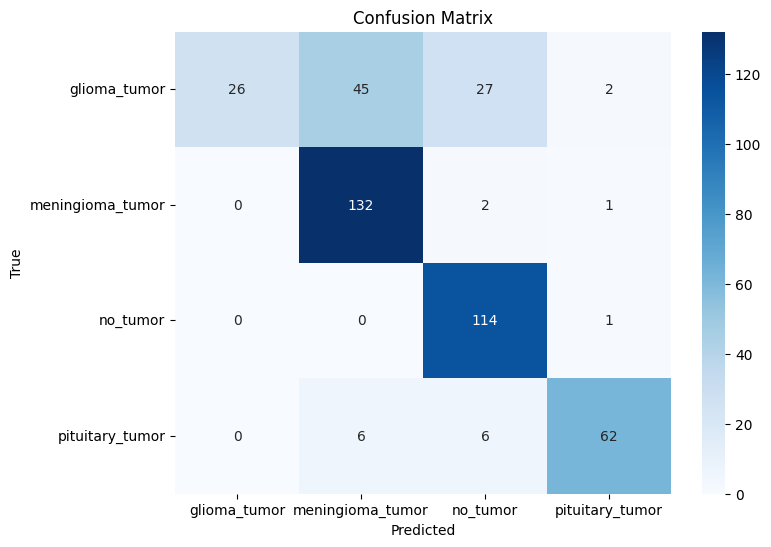

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
confusion_matrix = [
    [26, 45, 27, 2],
    [0, 132, 2, 1],
    [0, 0, 114, 1],
    [0, 6, 6, 62]
]

# Class labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
